In [1]:
!pip3 install python-chess

In [42]:
import pandas as pd
import ast
from collections import defaultdict as dd
import regex as re
import seaborn as sns
import numpy as np
import chess
from itertools import chain


# Descriptive Analytics

In [67]:
df = pd.read_csv("sample.csv", header=0, index_col = 0)

/home/isaac/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [68]:
df.head()

,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,BIsComp,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves
0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"['d4', 'c4', 'Nf3', 'e3', 'Bxc4', 'Be2', 'Bd2'...","['d5', 'c6', 'dxc4', 'e6', 'b5', 'Bb4+', 'Bxd2..."
1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,NaN,NaN,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"['e4', 'Nf3', 'd4', 'dxe5', 'Nc3', 'Nd5', 'Bd2...","['e5', 'd6', 'Qe7', 'dxe5', 'f6', 'Qd6', 'c6',..."
2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"['d4', 'g3', 'Bg2', 'Nf3', 'O-O', 'e3', 'c3', ...","['d5', 'b5', 'Bb7', 'h6', 'e6', 'Bd6', 'Nf6', ..."
3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,NaN,NaN,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"['e4', 'd4', 'dxe5', 'exd5', 'Nf3', 'Be2', 'Bx...","['d5', 'e5', 'Nc6', 'Nxe5', 'Bg4', 'Nxf3+', 'B..."
4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,NaN,NaN,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"['e4', 'd4', 'f4', 'c3', 'cxd4', 'e5', 'Nc3', ...","['g6', 'Bg7', 'c5', 'cxd4', 'd5', 'Nc6', 'Nh6'..."


In [69]:
df["BMoves"] = df["BMoves"].apply(ast.literal_eval)
df["WMoves"] = df["WMoves"].apply(ast.literal_eval)

df = df[df["WElo"] != "eow"]
df = df.reset_index()

df["BElo"] = df["BElo"].astype(int)
df["WElo"] = df["WElo"].astype(int)

In [16]:
df.loc[2,'WMoves']

['d4',
 'g3',
 'Bg2',
 'Nf3',
 'O-O',
 'e3',
 'c3',
 'a4',
 'Ne5',
 'cxb4',
 'Na3',
 'Nb5',
 'Nc4',
 'Nxa5',
 'Nc6',
 'Nbxa7',
 'Ne5',
 'Nb5',
 'Ra3',
 'Bd2',
 'Rb3',
 'dxe5',
 'a5',
 'Bb4',
 'Bxf8',
 'Rxb7',
 'Qc2',
 'Bxe4',
 'Qxe4',
 'Ra1',
 'Rxb2',
 'exf6',
 'Ra8+',
 'Rb7#']

## Most popular square?

In [57]:
lookups = [
    ("^.*[a-h][1-8].*$", "normal move"),
    ("^O-O$", "kingside castle"),
    ("^O-O-O$", "queenside castle"),
    ("^.+[QNBR]\+*#*$", "pawn conversion"),
    ("^.*\+$", "check"),
    ("^.*#$", "checkmate")
]

def is_not_castle(move):
    return not bool(re.search("O-O",move))


In [7]:
square_dict = dd(int)

def count_squares(moves, colour):
    for move in moves:
        if is_not_castle(move):
            square_dict[re.findall("[a-h][1-8]",move)[-1]] += 1
        else:
            if re.search("^O-O$", move):
                if colour=="W":
                    square_dict["g1"] += 1
                else:
                    square_dict["g8"] += 1
            else: 
                if colour=="W":
                    square_dict["c1"] += 1
                else:
                    square_dict["c8"] += 1
    return


In [12]:
df["BMoves"].apply(lambda x : count_squares(x,'B'))
df["WMoves"].apply(lambda x : count_squares(x,'W'))

0        None
1        None
2        None
3        None
4        None
         ... 
39255    None
39256    None
39257    None
39258    None
39259    None
Name: WMoves, Length: 39260, dtype: object

## How many moves until a game becomes unique?

In [16]:
df.loc[195]

Event          FICS rated blitz game
Site              FICS freechess.org
GameNumber                 470452174
WName                         AhNeow
BName                          limun
WElo                            1478
BElo                            1540
WRD                             28.8
BRD                             25.5
WIsComp                          NaN
BIsComp                          NaN
TimeControl                    240+0
Date                      2020.01.31
Time                        23:01:00
WClock                       04:00.0
BClock                       04:00.0
ECO                              A00
PlyCount                           0
Result                           1-0
WMoves                            []
BMoves                            []
Name: 195, dtype: object

In [17]:
sample_df = df.head(1000)

In [25]:
moves_until_unique = dd(int)

for i in range(len(sample_df["WMoves"])):
    for j in range(i,len(sample_df["WMoves"])):
        move_count = -1
        g1move = ""
        g2move = ""
        while g1move==g2move:
            move_count += 1
            try:
                if move_count%2 == 0:
                    #White's move
                    g1move = df["WMoves"][i][move_count//2]
                    g2move = df["WMoves"][j][move_count//2]
                else:
                    #Black's move
                    g1move = df["BMoves"][i][move_count//2]
                    g2move = df["BMoves"][j][move_count//2]
            except:
                #end of game
                g1move = 1
                g2move = 2
        if moves_until_unique[i] < move_count:
            moves_until_unique[i] = move_count
        if moves_until_unique[j] < move_count:
            moves_until_unique[j] = move_count
            

In [19]:
moves_until_unique

defaultdict(int,
            {0: 43,
             1: 48,
             2: 67,
             3: 23,
             4: 53,
             5: 96,
             6: 89,
             7: 68,
             8: 53,
             9: 48,
             10: 106,
             11: 49,
             12: 74,
             13: 73,
             14: 90,
             15: 23,
             16: 13,
             17: 94,
             18: 110,
             19: 139,
             20: 59,
             21: 59,
             22: 16,
             23: 104,
             24: 34,
             25: 49,
             26: 129,
             27: 39,
             28: 74,
             29: 114,
             30: 134,
             31: 60,
             32: 46,
             33: 58,
             34: 81,
             35: 98,
             36: 45,
             37: 43,
             38: 71,
             39: 61,
             40: 97,
             41: 109,
             42: 41,
             43: 101,
             44: 70,
             45: 127,
             46: 

## CapturesByPiece
function takes as argument the pandas dataframe and returns the pandas dataframe with capture count for pair of pieces

In [26]:
def capturesByPiece(df):
    # Dict of dict to store the count of captures made by a piece

    captureCount = dict()
    for attacker in chess.UNICODE_PIECE_SYMBOLS.keys():
        captureCount[attacker] = dict()
        for captured in chess.UNICODE_PIECE_SYMBOLS.keys():
            captureCount[attacker][captured] = 0
    
  
            
    for index, row in df.iterrows():
        WMoves = row["WMoves"]
        BMoves = row["BMoves"]

        board = chess.Board()

        # zipping all the moves and merging into one list 
        allMoves = zip(WMoves, BMoves)
        zippedMoves = list(chain.from_iterable(allMoves))

        for move in zippedMoves:
            if board.is_capture(board.parse_san(move)):
                moveInUCI = board.uci(board.parse_san(move))
#                 print("move:",move)
                attackerPosition, capturedPosition = moveInUCI[:2], moveInUCI[2:4]
#                 print("ap,cp:"+attackerPosition, capturedPosition)
                attacker = board.piece_at(chess.SQUARE_NAMES.index(attackerPosition))
                captured = board.piece_at(chess.SQUARE_NAMES.index(capturedPosition))
#                 print("a,c:",attacker,captured)
                
                if (str(attacker) in captureCount.keys()) and (str(captured) in captureCount.keys()):
                    captureCount[str(attacker)][str(captured)] += 1
        
            board.push_san(move)
        
#         print()
    
    capture_count = pd.DataFrame(captureCount)
    capture_count.rename(columns = chess.UNICODE_PIECE_SYMBOLS, index =  chess.UNICODE_PIECE_SYMBOLS, inplace = True) 

    return  capture_count

CPU times: user 432 ms, sys: 135 ms, total: 567 ms
Wall time: 416 ms


<AxesSubplot:>

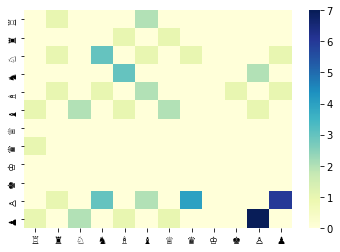

In [27]:
%%time
sns.heatmap(capturesByPiece(df.head(5)), cmap="YlGnBu")

# Prescriptive Analytics

## Feature Engineering

## Add columns for who won game

In [70]:
def get_player_result(result, colour):
    if colour=='B':
        if result[-1]=='0':
            return 0
        else:
            return 1
    else:
        if result[0]=='0':
            return 0
        else:
            return 1

def add_WL_columns(df):
    df['WResult'] = df["Result"].apply(lambda x: get_player_result(x, 'W'))
    df['BResult'] = df["Result"].apply(lambda x: get_player_result(x, 'B'))
    return

In [71]:
add_WL_columns(df)

In [72]:
df.head()

,index,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,BIsComp,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves,WResult,BResult
0,0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"[d4, c4, Nf3, e3, Bxc4, Be2, Bd2, Nbxd2, a4, O...","[d5, c6, dxc4, e6, b5, Bb4+, Bxd2+, Nf6, Bd7, ...",1,0
1,1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,NaN,NaN,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"[e4, Nf3, d4, dxe5, Nc3, Nd5, Bd2, Bb4, Bxf8, ...","[e5, d6, Qe7, dxe5, f6, Qd6, c6, Qd7, cxd5, dx...",0,1
2,2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"[d4, g3, Bg2, Nf3, O-O, e3, c3, a4, Ne5, cxb4,...","[d5, b5, Bb7, h6, e6, Bd6, Nf6, b4, O-O, Bxb4,...",1,0
3,3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,NaN,NaN,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"[e4, d4, dxe5, exd5, Nf3, Be2, Bxf3, Qxf3, Bg5...","[d5, e5, Nc6, Nxe5, Bg4, Nxf3+, Bxf3, Nf6, Be7...",1,0
4,4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,NaN,NaN,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"[e4, d4, f4, c3, cxd4, e5, Nc3, Bb5, Nf3, Be3,...","[g6, Bg7, c5, cxd4, d5, Nc6, Nh6, O-O, Bg4, Nf...",0,1


## Add columns for pawn conversions

In [73]:
def get_conversions(moves):
    conversions = []
    for move in moves:
        if re.match(lookups[3][0], move) is not None:
            conversions.append(re.search("(?<=[a-h][1-8]=)[QNBR]",move).group(0))
    return len(conversions)

def add_conversions_columns(df):
    df["WConversions"] = df["WMoves"].apply(lambda x: get_conversions(x))
    df["BConversions"] = df["BMoves"].apply(lambda x: get_conversions(x))

In [74]:
add_conversions_columns(df)

**Add columns for what piece was used the most by a player**

In [75]:
df['WFavPiece'] = 'null'
df['BFavPiece'] = 'null'

WPieceMoves = {'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K':0}
BPieceMoves = {'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K':0}

def get_favPiece():
    for i in range(len(df)):
        moves = df.loc[i, 'WMoves']
        for move in moves:
            if(move):
                if move[0].isupper() and move[0] != 'O':
                    WPieceMoves[move[0]] += 1
        FavPiece = max(WPieceMoves, key=WPieceMoves.get)
        df.loc[i, ['WFavPiece']] = FavPiece
        
        moves = df.loc[i, 'BMoves']
        for move in moves:
            if(move):
                if move[0].isupper() and move[0] != 'O':
                    BPieceMoves[move[0]] += 1
        FavPiece = max(BPieceMoves, key=BPieceMoves.get)
        df.loc[i, ['BFavPiece']] = FavPiece

In [76]:
get_favPiece()

In [113]:
Wfavpiece_dummies = pd.get_dummies(df.WFavPiece, prefix='WFav')
Bfavpiece_dummies = pd.get_dummies(df.BFavPiece, prefix='BFav')
df = pd.concat([df, Wfavpiece_dummies], axis=1)
df = pd.concat([df, Bfavpiece_dummies], axis=1)


In [114]:
df.head()

,index,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,BIsComp,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves,WResult,BResult,WConversions,BConversions,WFavPiece,BFavPiece,WCaptureMovesCount,BCaptureMovesCount,WOrdMovesCount,BOrdMovesCount,WPiecesCount,BPiecesCount,BCheck,WCheck,BChecked,WChecked,bOpens,wOpens,WFav_B,WFav_N,WFav_Q,WFav_R,BFav_B,BFav_N,BFav_Q
0,0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"[d4, c4, Nf3, e3, Bxc4, Be2, Bd2, Nbxd2, a4, O...","[d5, c6, dxc4, e6, b5, Bb4+, Bxd2+, Nf6, Bd7, ...",1,0,0,0,Q,N,7,5,15,16,11,9,5,0,0,5,"(d4, c4, Nf3, e3, Bxc4)","(d4, c4, Nf3, e3, Bxc4)",0,0,1,0,0,1,0
1,1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,NaN,NaN,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"[e4, Nf3, d4, dxe5, Nc3, Nd5, Bd2, Bb4, Bxf8, ...","[e5, d6, Qe7, dxe5, f6, Qd6, c6, Qd7, cxd5, dx...",0,1,0,0,N,Q,4,6,20,18,10,12,0,11,11,0,"(e4, Nf3, d4, dxe5, Nc3)","(e4, Nf3, d4, dxe5, Nc3)",0,1,0,0,0,0,1
2,2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"[d4, g3, Bg2, Nf3, O-O, e3, c3, a4, Ne5, cxb4,...","[d5, b5, Bb7, h6, e6, Bd6, Nf6, b4, O-O, Bxb4,...",1,0,0,0,N,Q,10,8,24,25,8,6,0,32,32,0,"(d4, g3, Bg2, Nf3, O-O)","(d4, g3, Bg2, Nf3, O-O)",0,1,0,0,0,0,1
3,3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,NaN,NaN,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"[e4, d4, dxe5, exd5, Nf3, Be2, Bxf3, Qxf3, Bg5...","[d5, e5, Nc6, Nxe5, Bg4, Nxf3+, Bxf3, Nf6, Be7...",1,0,0,0,N,N,5,3,7,8,13,11,5,0,0,5,"(e4, d4, dxe5, exd5, Nf3)","(e4, d4, dxe5, exd5, Nf3)",0,1,0,0,0,1,0
4,4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,NaN,NaN,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"[e4, d4, f4, c3, cxd4, e5, Nc3, Bb5, Nf3, Be3,...","[g6, Bg7, c5, cxd4, d5, Nc6, Nh6, O-O, Bg4, Nf...",0,1,0,0,N,N,5,10,22,16,6,11,15,0,0,15,"(e4, d4, f4, c3, cxd4)","(e4, d4, f4, c3, cxd4)",0,1,0,0,0,1,0


## Moves Count
Moves can either be ordinary move or capturing move, 
 - `WCaptureMovesCount` represent number of capturing moves in the game made by White player
 - `BCaptureMovesCount` represent number of capturing moves in the game made by Black player
 - `WOrdMovesCount` represent number of ordinary moves in the game made by White player
 - `BOrdMovesCount` represent number of oridnary moves in the game made by Black player

In [78]:
def captureCount(moves):
    count = 0
    for move in moves:
        if "x" in move:
            count += 1
    return count
            

In [79]:
def ordinaryCount(moves):
    count = 0
    for move in moves:
        if "x" not in move:
            count += 1
    return count

In [80]:
def addmovesCount():
    df["WCaptureMovesCount"] = df["WMoves"].apply(captureCount)
    df["BCaptureMovesCount"] = df["BMoves"].apply(captureCount)

    df["WOrdMovesCount"] = df["WMoves"].apply(ordinaryCount)

    df["BOrdMovesCount"] = df["BMoves"].apply(ordinaryCount)

In [81]:
addmovesCount()

In [82]:
df.head()

,index,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,BIsComp,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves,WResult,BResult,WConversions,BConversions,WFavPiece,BFavPiece,WCaptureMovesCount,BCaptureMovesCount,WOrdMovesCount,BOrdMovesCount
0,0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"[d4, c4, Nf3, e3, Bxc4, Be2, Bd2, Nbxd2, a4, O...","[d5, c6, dxc4, e6, b5, Bb4+, Bxd2+, Nf6, Bd7, ...",1,0,0,0,Q,N,7,5,15,16
1,1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,NaN,NaN,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"[e4, Nf3, d4, dxe5, Nc3, Nd5, Bd2, Bb4, Bxf8, ...","[e5, d6, Qe7, dxe5, f6, Qd6, c6, Qd7, cxd5, dx...",0,1,0,0,N,Q,4,6,20,18
2,2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"[d4, g3, Bg2, Nf3, O-O, e3, c3, a4, Ne5, cxb4,...","[d5, b5, Bb7, h6, e6, Bd6, Nf6, b4, O-O, Bxb4,...",1,0,0,0,N,Q,10,8,24,25
3,3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,NaN,NaN,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"[e4, d4, dxe5, exd5, Nf3, Be2, Bxf3, Qxf3, Bg5...","[d5, e5, Nc6, Nxe5, Bg4, Nxf3+, Bxf3, Nf6, Be7...",1,0,0,0,N,N,5,3,7,8
4,4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,NaN,NaN,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"[e4, d4, f4, c3, cxd4, e5, Nc3, Bb5, Nf3, Be3,...","[g6, Bg7, c5, cxd4, d5, Nc6, Nh6, O-O, Bg4, Nf...",0,1,0,0,N,N,5,10,22,16


## Number of pieces at the end of the game

In [83]:
def addpieces():
    df["WPiecesCount"] = np.abs(df["BCaptureMovesCount"].subtract(16))

    df["BPiecesCount"] = np.abs(df["WCaptureMovesCount"].subtract(16))

In [84]:
addpieces()

In [85]:
df.head()

,index,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,BIsComp,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves,WResult,BResult,WConversions,BConversions,WFavPiece,BFavPiece,WCaptureMovesCount,BCaptureMovesCount,WOrdMovesCount,BOrdMovesCount,WPiecesCount,BPiecesCount
0,0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"[d4, c4, Nf3, e3, Bxc4, Be2, Bd2, Nbxd2, a4, O...","[d5, c6, dxc4, e6, b5, Bb4+, Bxd2+, Nf6, Bd7, ...",1,0,0,0,Q,N,7,5,15,16,11,9
1,1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,NaN,NaN,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"[e4, Nf3, d4, dxe5, Nc3, Nd5, Bd2, Bb4, Bxf8, ...","[e5, d6, Qe7, dxe5, f6, Qd6, c6, Qd7, cxd5, dx...",0,1,0,0,N,Q,4,6,20,18,10,12
2,2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"[d4, g3, Bg2, Nf3, O-O, e3, c3, a4, Ne5, cxb4,...","[d5, b5, Bb7, h6, e6, Bd6, Nf6, b4, O-O, Bxb4,...",1,0,0,0,N,Q,10,8,24,25,8,6
3,3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,NaN,NaN,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"[e4, d4, dxe5, exd5, Nf3, Be2, Bxf3, Qxf3, Bg5...","[d5, e5, Nc6, Nxe5, Bg4, Nxf3+, Bxf3, Nf6, Be7...",1,0,0,0,N,N,5,3,7,8,13,11
4,4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,NaN,NaN,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"[e4, d4, f4, c3, cxd4, e5, Nc3, Bb5, Nf3, Be3,...","[g6, Bg7, c5, cxd4, d5, Nc6, Nh6, O-O, Bg4, Nf...",0,1,0,0,N,N,5,10,22,16,6,11


## Pairwise capture count
    - Uppercase letter(R,N,B,Q,K,P) represent White pieces 
    - lowercase letter(r,n,b,q,k,p) represent Black pieces
    - Column "Pp" represent P captures p count

In [86]:
def pairCaptureDict(WMoves, BMoves):
#     Dictionary to store count
    captureCount = dict()
    for attacker in chess.UNICODE_PIECE_SYMBOLS.keys():
        for captured in chess.UNICODE_PIECE_SYMBOLS.keys():
            key = attacker+captured
            if (not key.isupper()) and (not key.islower()):
                captureCount[key] = 0
                
                
    board = chess.Board()
 # zipping all the moves and merging into one list 
    allMoves = zip(WMoves, BMoves)
    zippedMoves = list(chain.from_iterable(allMoves))

    for move in zippedMoves:
        if board.is_capture(board.parse_san(move)):
            moveInUCI = board.uci(board.parse_san(move))
#                 print("move:",move)
            attackerPosition, capturedPosition = moveInUCI[:2], moveInUCI[2:4]
#                 print("ap,cp:"+attackerPosition, capturedPosition)
            attacker = board.piece_at(chess.SQUARE_NAMES.index(attackerPosition))
            captured = board.piece_at(chess.SQUARE_NAMES.index(capturedPosition))
#                 print("a,c:",attacker,captured)
            key = (str(attacker)+str(captured))
            if (key in captureCount.keys()):
                    captureCount[key] += 1
        board.push_san(move)
    return captureCount


In [ ]:
#  Adds the features to the dataframe 
df['pairCaptureDict'] = df.apply(lambda x: pairCaptureDict(x.WMoves, x.BMoves), axis=1)

new_df = pd.DataFrame(list(df["pairCaptureDict"]))

df = pd.concat([df, new_df], axis=1)

df = df.drop(columns = "pairCaptureDict")

In [61]:
df.head()

,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,BIsComp,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves,WResult,BResult,WConversions,BConversions,WFavPiece,BFavPiece
0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"[d4, c4, Nf3, e3, Bxc4, Be2, Bd2, Nbxd2, a4, O...","[d5, c6, dxc4, e6, b5, Bb4+, Bxd2+, Nf6, Bd7, ...",1,0,0,0,Q,N
1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,NaN,NaN,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"[e4, Nf3, d4, dxe5, Nc3, Nd5, Bd2, Bb4, Bxf8, ...","[e5, d6, Qe7, dxe5, f6, Qd6, c6, Qd7, cxd5, dx...",0,1,0,0,N,Q
2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"[d4, g3, Bg2, Nf3, O-O, e3, c3, a4, Ne5, cxb4,...","[d5, b5, Bb7, h6, e6, Bd6, Nf6, b4, O-O, Bxb4,...",1,0,0,0,N,Q
3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,NaN,NaN,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"[e4, d4, dxe5, exd5, Nf3, Be2, Bxf3, Qxf3, Bg5...","[d5, e5, Nc6, Nxe5, Bg4, Nxf3+, Bxf3, Nf6, Be7...",1,0,0,0,N,N
4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,NaN,NaN,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"[e4, d4, f4, c3, cxd4, e5, Nc3, Bb5, Nf3, Be3,...","[g6, Bg7, c5, cxd4, d5, Nc6, Nh6, O-O, Bg4, Nf...",0,1,0,0,N,N


## finding first check

In [62]:
def find_check(entry):
    n_moves = 0;
    for i in range(len(entry["WMoves"])):
        n_moves+=1
        if entry["WMoves"][i][-1] == "+":
            return n_moves
        if i == len(entry["WMoves"]) - 1 and len(entry["WMoves"]) != len(entry["BMoves"]):
            return -1
        if entry["BMoves"][i][-1] == "+":
            return n_moves
    return -1

def find_checks(df):
    chks = []
    for i in range(len(df)):
        chks.append(find_check(df.iloc[i]))
    df["first_check"] = chks

In [87]:
def get_check(moves):
    for i in range(len(moves)):
        if moves[i][-1] == "+":
            return i
    else:
        return 0

def make_check_columns(df):
    df["BCheck"] = df["BMoves"].apply(lambda x: get_check(x))
    df["WCheck"] = df["WMoves"].apply(lambda x: get_check(x))
    df["BChecked"] = df["WMoves"].apply(lambda x: get_check(x))
    df["WChecked"] = df["BMoves"].apply(lambda x: get_check(x))

In [88]:
make_check_columns(df)

In [ ]:
pd.set_option('display.max_columns', None)

## High skill openings

In [89]:
def high_skill_openings(df):
    open_elo = dd(int)
    open_count = dd(int)
    bOpens = []
    wOpens = []
    for i in range(len(df)):
        wOpen = tuple(df["WMoves"][i][0:5])
        wOpens.append(wOpen)
        wSkill = df["WElo"][i]
        open_elo[wOpen] += wSkill
        open_count[wOpen] += 1
        bOpen = tuple(df["BMoves"][i][0:5])
        bOpens.append(wOpen)
        bSkill = df["BElo"][i]
        open_elo[bOpen] += bSkill
        open_count[bOpen] += 1
        
    for key in open_elo.keys():
        open_elo[key] = open_elo[key]/open_count[key]
    return open_elo, bOpens, wOpens

def openings(df):
    elos, bOpens, wOpens = high_skill_openings(df)
    df["bOpens"] = bOpens
    df["wOpens"] = wOpens

In [90]:
openings(df)

In [91]:
df.head()

,index,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,WIsComp,BIsComp,TimeControl,Date,Time,WClock,BClock,ECO,PlyCount,Result,WMoves,BMoves,WResult,BResult,WConversions,BConversions,WFavPiece,BFavPiece,WCaptureMovesCount,BCaptureMovesCount,WOrdMovesCount,BOrdMovesCount,WPiecesCount,BPiecesCount,BCheck,WCheck,BChecked,WChecked,bOpens,wOpens
0,0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D11,43,1-0,"[d4, c4, Nf3, e3, Bxc4, Be2, Bd2, Nbxd2, a4, O...","[d5, c6, dxc4, e6, b5, Bb4+, Bxd2+, Nf6, Bd7, ...",1,0,0,0,Q,N,7,5,15,16,11,9,5,0,0,5,"(d4, c4, Nf3, e3, Bxc4)","(d4, c4, Nf3, e3, Bxc4)"
1,1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,NaN,NaN,180+2,2020.01.31,23:52:00,03:00.0,03:00.0,C41,48,0-1,"[e4, Nf3, d4, dxe5, Nc3, Nd5, Bd2, Bb4, Bxf8, ...","[e5, d6, Qe7, dxe5, f6, Qd6, c6, Qd7, cxd5, dx...",0,1,0,0,N,Q,4,6,20,18,10,12,0,11,11,0,"(e4, Nf3, d4, dxe5, Nc3)","(e4, Nf3, d4, dxe5, Nc3)"
2,2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,Yes,NaN,300+0,2020.01.31,23:54:00,05:00.0,05:00.0,D00,67,1-0,"[d4, g3, Bg2, Nf3, O-O, e3, c3, a4, Ne5, cxb4,...","[d5, b5, Bb7, h6, e6, Bd6, Nf6, b4, O-O, Bxb4,...",1,0,0,0,N,Q,10,8,24,25,8,6,0,32,32,0,"(d4, g3, Bg2, Nf3, O-O)","(d4, g3, Bg2, Nf3, O-O)"
3,3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,NaN,NaN,120+12,2020.01.31,23:55:00,02:00.0,02:00.0,D00,23,1-0,"[e4, d4, dxe5, exd5, Nf3, Be2, Bxf3, Qxf3, Bg5...","[d5, e5, Nc6, Nxe5, Bg4, Nxf3+, Bxf3, Nf6, Be7...",1,0,0,0,N,N,5,3,7,8,13,11,5,0,0,5,"(e4, d4, dxe5, exd5, Nf3)","(e4, d4, dxe5, exd5, Nf3)"
4,4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,NaN,NaN,300+2,2020.01.31,23:48:00,05:00.0,05:00.0,B06,53,0-1,"[e4, d4, f4, c3, cxd4, e5, Nc3, Bb5, Nf3, Be3,...","[g6, Bg7, c5, cxd4, d5, Nc6, Nh6, O-O, Bg4, Nf...",0,1,0,0,N,N,5,10,22,16,6,11,15,0,0,15,"(e4, d4, f4, c3, cxd4)","(e4, d4, f4, c3, cxd4)"


In [133]:
BX = df[["BResult", "BConversions", "BCaptureMovesCount", "BOrdMovesCount","BPiecesCount","BCheck","BChecked"]]
By = df["BElo"]

In [183]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, RidgeCV, SGDRegressor, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor

train_bx, test_bx, train_by, test_by= train_test_split(BX, By)

In [186]:
models = [Perceptron, RidgeCV, SGDRegressor, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, BayesianRidge]
for model in models:
    cur_model = model()
type(model).__name__

'RidgeCV'

In [179]:
model = RidgeCV()
model.fit(train_bx, train_by)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [180]:
by_pred = model.predict(test_bx)

In [182]:
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(by_pred, test_by))
mean_squared_error(by_pred, test_by)

-22.837381110219717


54159.40614531818

In [162]:
from math import sqrt
sqrt(60000)

244.94897427831782

In [167]:
bmean = df["BElo"].mean()
bmeans = [bmean for i in range(len(by_pred))]